In [1]:
# utility
import sys
sys.path.append("..")

import utility

# data processing
import numpy as np

# modelling keras
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Lambda, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import L1L2, L1, L2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, BinaryCrossentropy
from sklearn.model_selection import train_test_split

# visualization
import matplotlib.pyplot as plt

In [2]:
start_time = utility.time.time()

stop_thread = False

# global parameters
max_cpu_usage = 0
max_memory_usage = 0

def collect_cpu_mem_usage():
    global max_cpu_usage, max_memory_usage

    while not stop_thread:
        # Get current CPU and memory usage
        cpu_usage = utility.psutil.cpu_percent()
        memory_usage = utility.psutil.virtual_memory().percent

        # Initialize variables if not yet assigned
        if max_cpu_usage is None:
            max_cpu_usage = cpu_usage
        if max_memory_usage is None:
            max_memory_usage = memory_usage

        # Update maximum values if needed
        max_cpu_usage = max(max_cpu_usage, cpu_usage)
        max_memory_usage = max(max_memory_usage, memory_usage)

        # Sleep for a short interval (adjust as needed)
        utility.time.sleep(1)

# Start the function in a separate thread
thread = utility.threading.Thread(target=collect_cpu_mem_usage)
thread.start()

In [3]:
train_data, test_data, val_data, train_labels, test_labels, val_labels, test_true_labels, anom_data = utility.preprocess_data(True, n_anomalies=12000, n_samples=-1)

345
Splitting data
normalize data
Reshape data
Convert data
Add anomalies


In [4]:
train_data, _, train_labels, _ = train_test_split(train_data, train_labels, test_size=0.4, random_state=42)

In [5]:
# data shape
print(train_data.shape)
print(test_data.shape)
print(val_data.shape)

# labels shape
print(train_labels.shape)
print(test_labels.shape)
print(val_labels.shape)
print(test_true_labels.shape)

(18153455, 784)
(10097253, 784)
(10085254, 784)
(18153455,)
(10097253,)
(10085254,)
(10097253,)


Dataset split: 18153455 train rows
Dataset split: 18153455 test rows


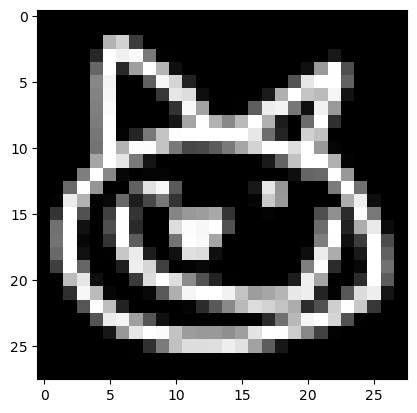

In [6]:
print(f"Dataset split: {len(train_data)} train rows")
print(f"Dataset split: {len(train_labels)} test rows")

point = train_data[0].reshape(28, 28)

plt.imshow(point, cmap='gray')
plt.show()

In [7]:
# Best Hyperparameters:
# {'optimizer': 'adam', 'activation': 'sigmoid', 'loss': <keras.src.losses.MeanSquaredError object at 0x7f8633cba920>, 'regularizer': None, 'dropout_rate': 0.0, 'epochs': 150, 'batch_size': 1024}
# Best Validation Loss: 0.024787141010165215

In [8]:
# parameters
epochs = 150
batch_size = 1024
optimizer = 'adam'
loss = MeanSquaredError()
regularizer = None
dropout_rate = 0.0
activation = 'sigmoid'

In [9]:
# Input layer
input_img = Input(shape=(784,))

In [10]:
# Encoder layers
encoded = Dense(256, activation='relu')(input_img)
encoded = BatchNormalization()(encoded)
encoded = Dropout(dropout_rate)(encoded)
encoded = Dense(128, activation='relu')(encoded)
encoded = Dropout(dropout_rate)(encoded)
encoded = Dense(64, activation='relu')(encoded)
encoded = Dropout(dropout_rate)(encoded)
encoded = Dense(32, activation='relu')(encoded)
encoded = Dropout(dropout_rate)(encoded)

In [11]:
# Decoder layers
decoded = Dense(32, activation='relu')(encoded)
decoded = Dense(64, activation='relu')(decoded)
decoded = Dropout(dropout_rate)(decoded)
decoded = Dense(128, activation='relu')(decoded)
decoded = BatchNormalization()(decoded)
decoded = Dropout(dropout_rate)(decoded)
decoded = Dense(256, activation='relu')(decoded)
decoded = Dropout(dropout_rate)(decoded)
decoded = Dense(784, activation=activation)(decoded)

In [12]:
autoencoder = Model(input_img, decoded)

In [13]:
autoencoder.compile(optimizer=optimizer, loss=loss)

In [14]:
# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model with early stopping
history = autoencoder.fit(train_data, train_data, epochs=epochs, batch_size=batch_size, shuffle=True,
                          validation_data=(val_data, val_data), callbacks=[early_stopping])

Epoch 1/150
17728/17728 [==============================] - 393s 22ms/step - loss: 0.0310 - val_loss: 0.0273
Epoch 2/150
17728/17728 [==============================] - 316s 18ms/step - loss: 0.0263 - val_loss: 0.0261
Epoch 3/150
17728/17728 [==============================] - 308s 17ms/step - loss: 0.0255 - val_loss: 0.0267
Epoch 4/150
17728/17728 [==============================] - 308s 17ms/step - loss: 0.0251 - val_loss: 0.0253
Epoch 5/150
17728/17728 [==============================] - 307s 17ms/step - loss: 0.0249 - val_loss: 0.0254
Epoch 6/150
17728/17728 [==============================] - 308s 17ms/step - loss: 0.0248 - val_loss: 0.0250
Epoch 7/150
17728/17728 [==============================] - 308s 17ms/step - loss: 0.0247 - val_loss: 0.0250
Epoch 8/150
17728/17728 [==============================] - 307s 17ms/step - loss: 0.0246 - val_loss: 0.0251
Epoch 9/150
17728/17728 [==============================] - 307s 17ms/step - loss: 0.0245 - val_loss: 0.0247
Epoch 10/150
17728/17728 [==

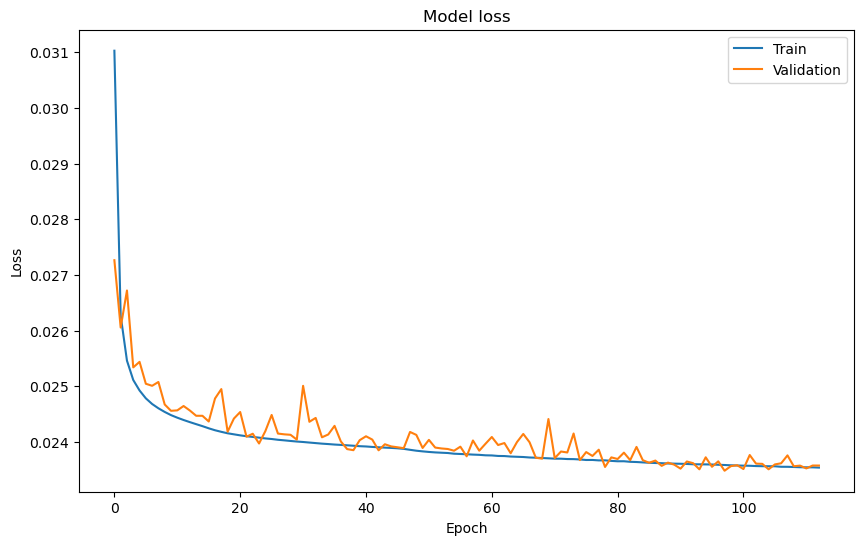

In [15]:
# Plot training history
plt.figure(figsize=(10, 6))

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [16]:
def generate_reconstructions(model, input_data, batch_size=2048):
    num_samples = input_data.shape[0]
    num_batches = int(np.ceil(num_samples / batch_size))

    # Initialize an empty array to store reconstructions
    all_reconstructions = np.empty_like(input_data)

    # Generate reconstructions in batches
    for i in range(num_batches):
        start_idx = i * batch_size
        end_idx = (i + 1) * batch_size

        # Extract a batch of data
        batch_data = input_data[start_idx:end_idx]

        # Generate reconstructions for the batch
        batch_reconstructions = model.predict(batch_data)

        # Store the reconstructions in the corresponding indices
        all_reconstructions[start_idx:end_idx] = batch_reconstructions

    return all_reconstructions

20/20 [==============================] - 0s 3ms/step


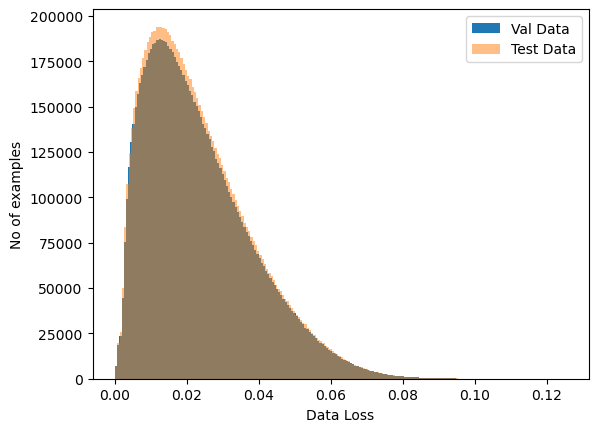

In [17]:
reconstructions = generate_reconstructions(autoencoder, val_data)
val_loss = tf.keras.losses.mse(reconstructions, val_data)

reconstructions_test = generate_reconstructions(autoencoder, test_data)
test_loss = tf.keras.losses.mse(reconstructions_test, test_data)

plt.hist(val_loss[None,:], bins=200, label='Val Data')
plt.hist(test_loss[None,:], bins=200, alpha=0.5, label='Test Data')
plt.xlabel("Data Loss")
plt.ylabel("No of examples")
plt.legend()
plt.show()

In [18]:
threshold = np.mean(val_loss) + np.std(val_loss)
print("Threshold ", threshold)

Threshold  0.03829494


In [19]:
threshold_anom = np.mean(test_loss) + np.std(test_loss)
print("Threshold ", threshold_anom)

Threshold  0.038284793


In [20]:
preds, loss, proba = utility.predict_in_batches(autoencoder, test_data, threshold)

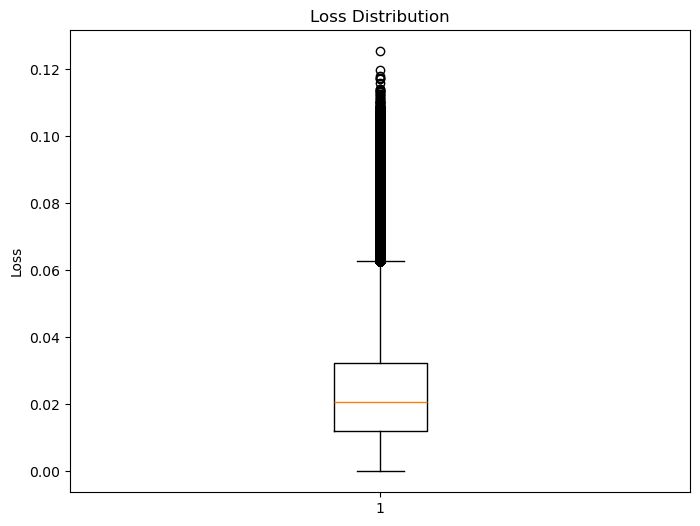

In [21]:
q1, q3, iqr, minimum, maximum = utility.boxplot_plot("Loss", loss)

In [22]:
utility.print_boxplot(q1, q3, iqr, minimum, maximum)

Q1:  0.012
Q3:  0.032
IQR:  0.02
Minimum:  0.0
Maximum:  0.063


/tmp/ipykernel_2266375/1046356683.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')


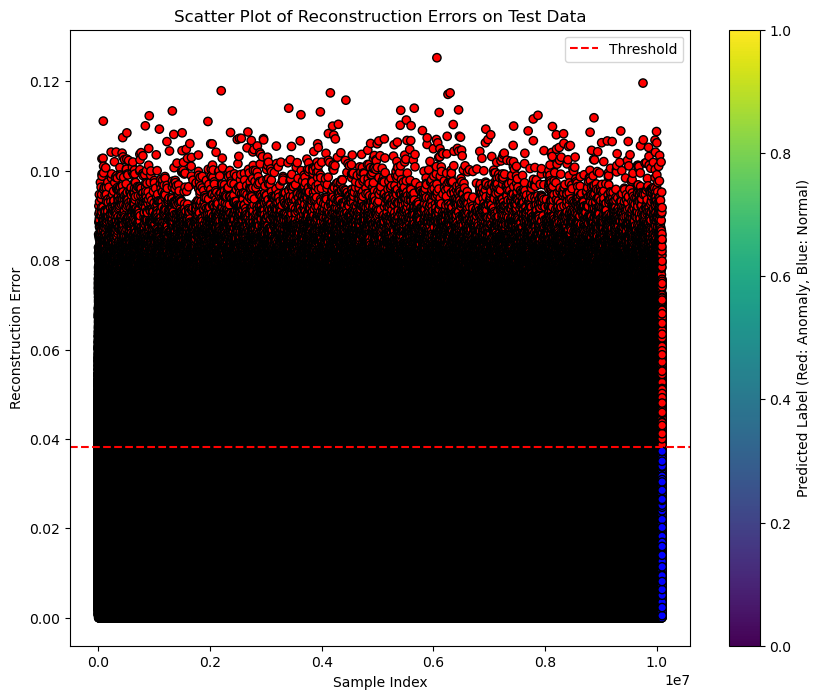

In [23]:
# Create a binary array indicating anomalies
anomaly_indicator = np.where(loss > threshold, 1, 0)

# Scatter plot with anomalies and normal instances based on anomaly prediction and threshold
plt.figure(figsize=(10, 8))
scatter = plt.scatter(range(len(loss)), loss, c=['red' if e > threshold else 'blue' for e in loss], cmap='coolwarm', marker='o', edgecolors='k')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Scatter Plot of Reconstruction Errors on Test Data')
plt.xlabel('Sample Index')
plt.ylabel('Reconstruction Error')
plt.legend()
plt.colorbar(scatter, label='Predicted Label (Red: Anomaly, Blue: Normal)')
plt.show()

In [24]:
a, p, r, f1, report, cm = utility.get_metrics(preds, test_true_labels)

In [25]:
utility.print_stats(a, p, r, f1, report, cm)

Accuracy = 0.8355692384849622
Precision = 0.9985802959517781
Recall = 0.8365629498833594
F1 = 0.9104196960893423
Report
               precision    recall  f1-score   support

     anomaly       0.00      0.00      0.00     12000
      normal       1.00      0.84      0.91  10085253

    accuracy                           0.84  10097253
   macro avg       0.50      0.42      0.46  10097253
weighted avg       1.00      0.84      0.91  10097253

Confusion Matrix
[[      5   11995]
 [1648304 8436949]]


True Negatives: 5
False Positives: 11995
False Negatives: 1648304
True Positives: 8436949


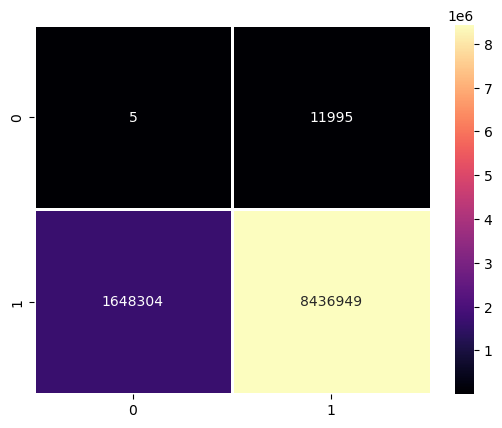

In [26]:
utility.create_heatmap(cm)

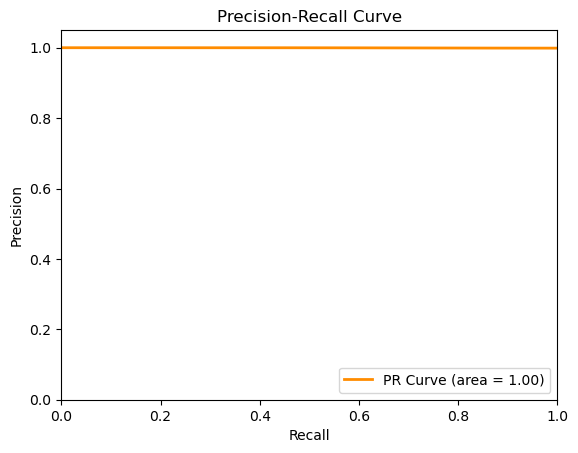

In [27]:
utility.pr_auc_plot(proba, test_true_labels)

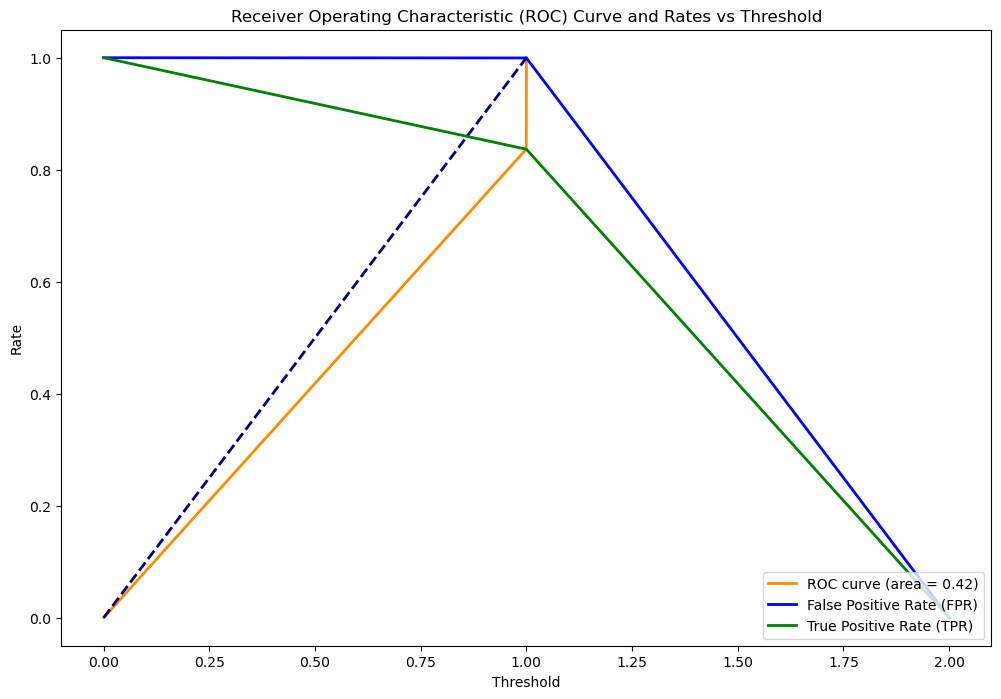

In [28]:
utility.roc_plot(preds, test_true_labels)

In [29]:
anomaly_indexes = utility.write_to_json(preds)

Anomaly indexes saved to ./anomalies.json


1648309


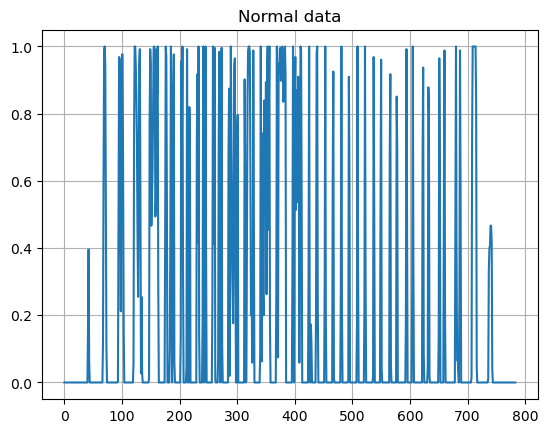

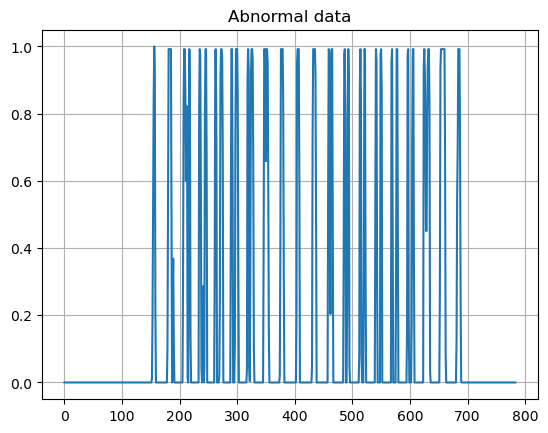

In [30]:
print(len(anomaly_indexes))

utility.plot_normalized_pixel_data(train_data, anom_data)

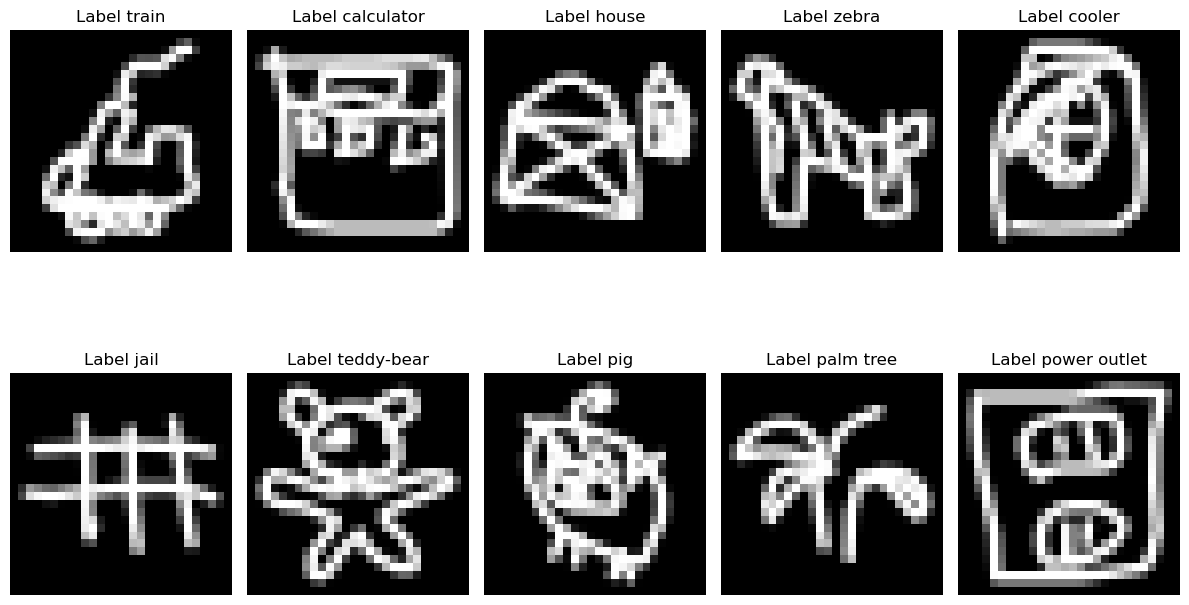

In [31]:
utility.plot_anomaly_imgs(anomaly_indexes, test_data, test_labels)

In [32]:
stop_thread = True

thread.join()
print(f"CPU Usage: {max_cpu_usage}%")
print(f"Memory Usage: {max_memory_usage}%")

CPU Usage: 96.9%
Memory Usage: 95.5%


In [33]:
end_time = utility.time.time()
total_time = end_time - start_time
print(f"Total execution time: {total_time} seconds")

Total execution time: 42615.730949401855 seconds
